#📌 Extracción

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Cargar los datos desde el archivo JSON
with open('TelecomX_Data.json', 'r') as f:
    data = json.load(f)

# Convertir a DataFrame
df = pd.json_normalize(data)

#🔧 Transformación

In [2]:
# Renombrar columnas para mayor claridad
df.columns = [col.replace('.', '_') for col in df.columns]

# Verificar valores faltantes
print(df.isnull().sum())

# Eliminar registros con Churn vacío (si los hay)
df = df[df['Churn'].isin(['Yes', 'No'])]

# Convertir SeniorCitizen a booleano
df['customer_SeniorCitizen'] = df['customer_SeniorCitizen'].astype(bool)

# Convertir cargos a numérico
df['account_Charges_Total'] = pd.to_numeric(df['account_Charges_Total'], errors='coerce')

# Crear variable binaria para Churn
df['Churn_bin'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Crear categorías de antigüedad
bins = [0, 12, 24, 36, 48, 60, 72]
labels = ['0-1 año', '1-2 años', '2-3 años', '3-4 años', '4-5 años', '5-6 años']
df['tenure_group'] = pd.cut(df['customer_tenure'], bins=bins, labels=labels, right=False)

customerID                   0
Churn                        0
customer_gender              0
customer_SeniorCitizen       0
customer_Partner             0
customer_Dependents          0
customer_tenure              0
phone_PhoneService           0
phone_MultipleLines          0
internet_InternetService     0
internet_OnlineSecurity      0
internet_OnlineBackup        0
internet_DeviceProtection    0
internet_TechSupport         0
internet_StreamingTV         0
internet_StreamingMovies     0
account_Contract             0
account_PaperlessBilling     0
account_PaymentMethod        0
account_Charges_Monthly      0
account_Charges_Total        0
dtype: int64


#📊 Carga y análisis

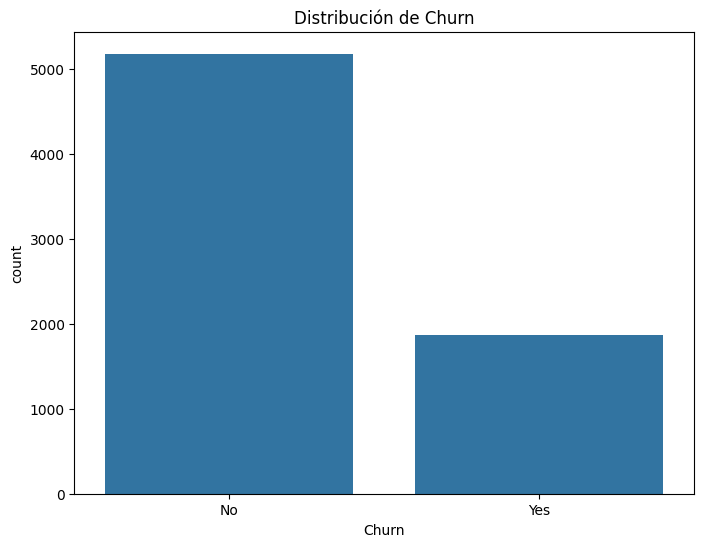

Tasa de Churn: 26.54%


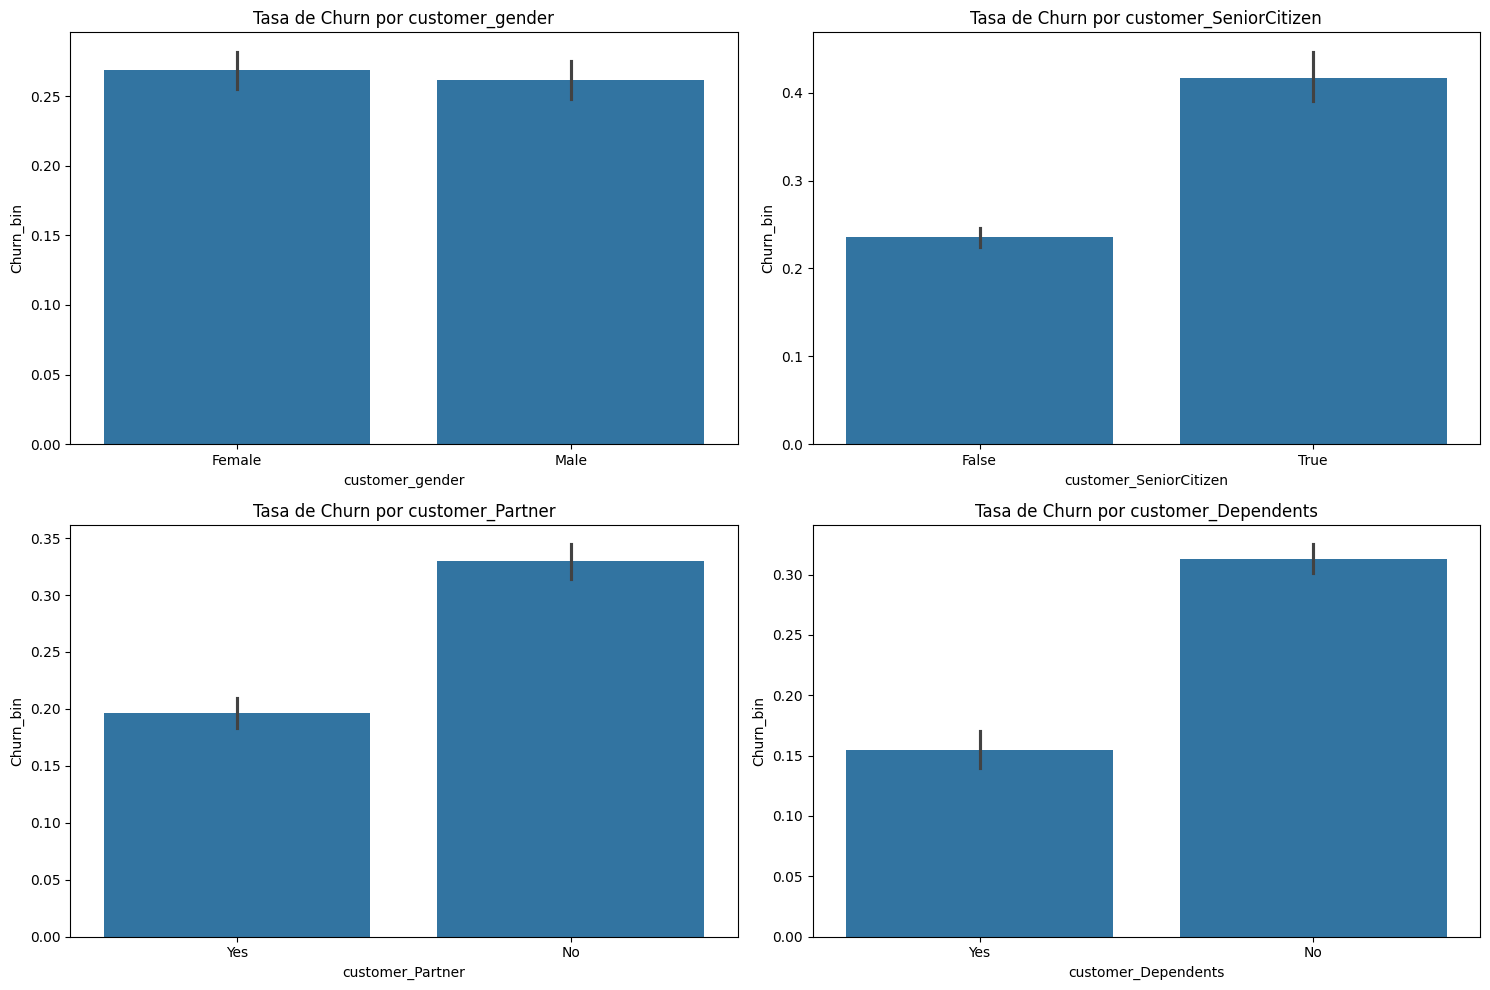

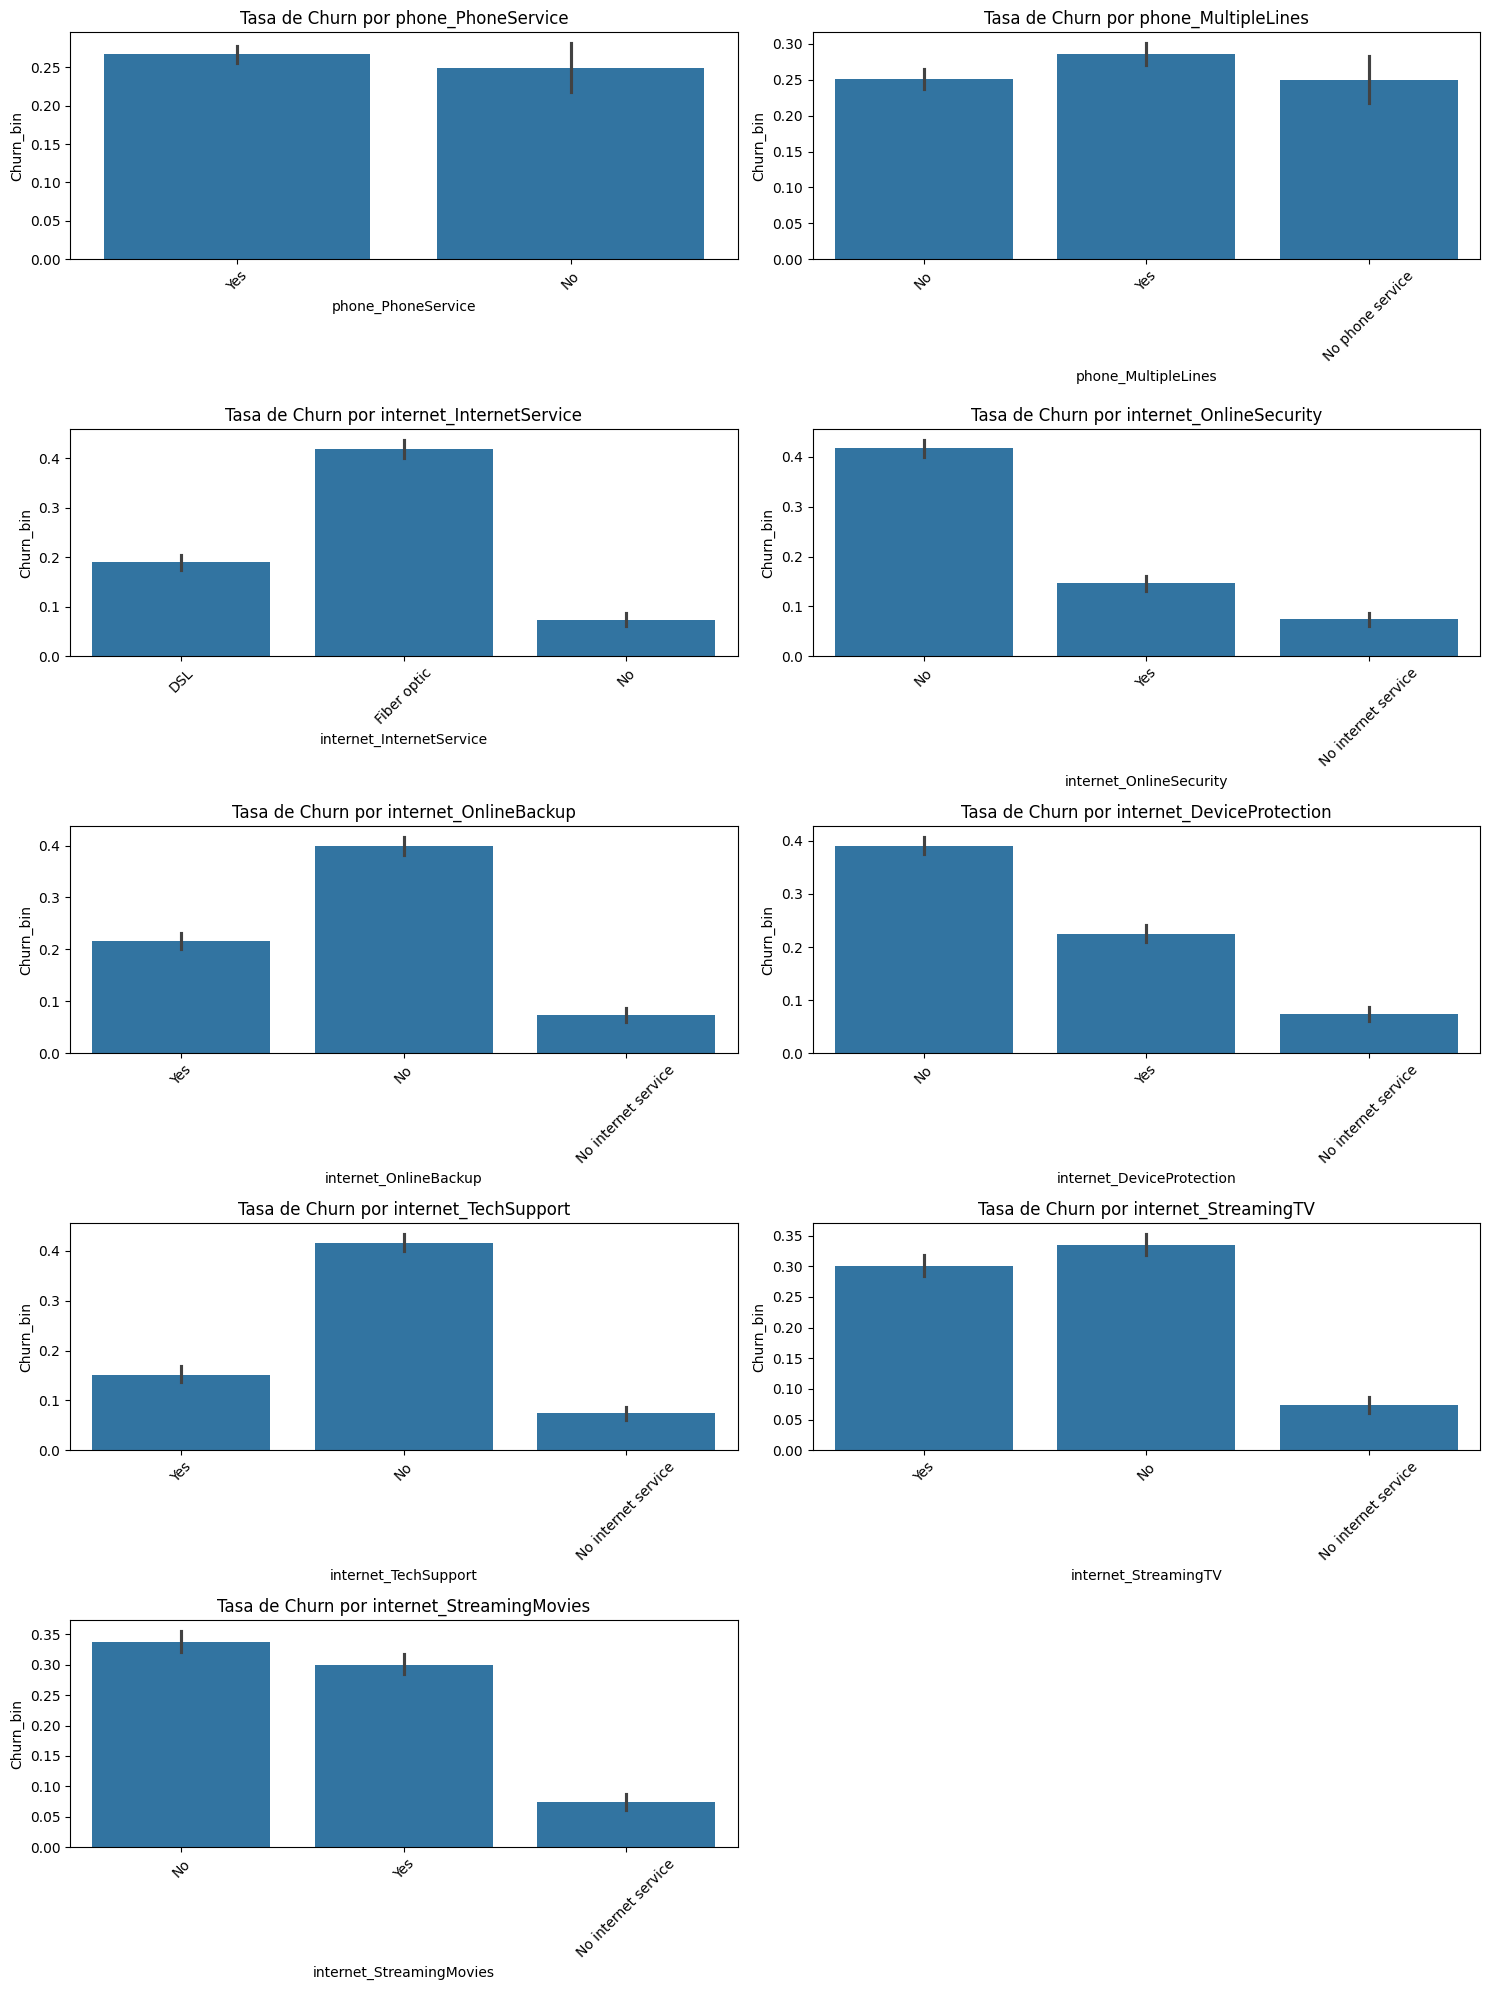

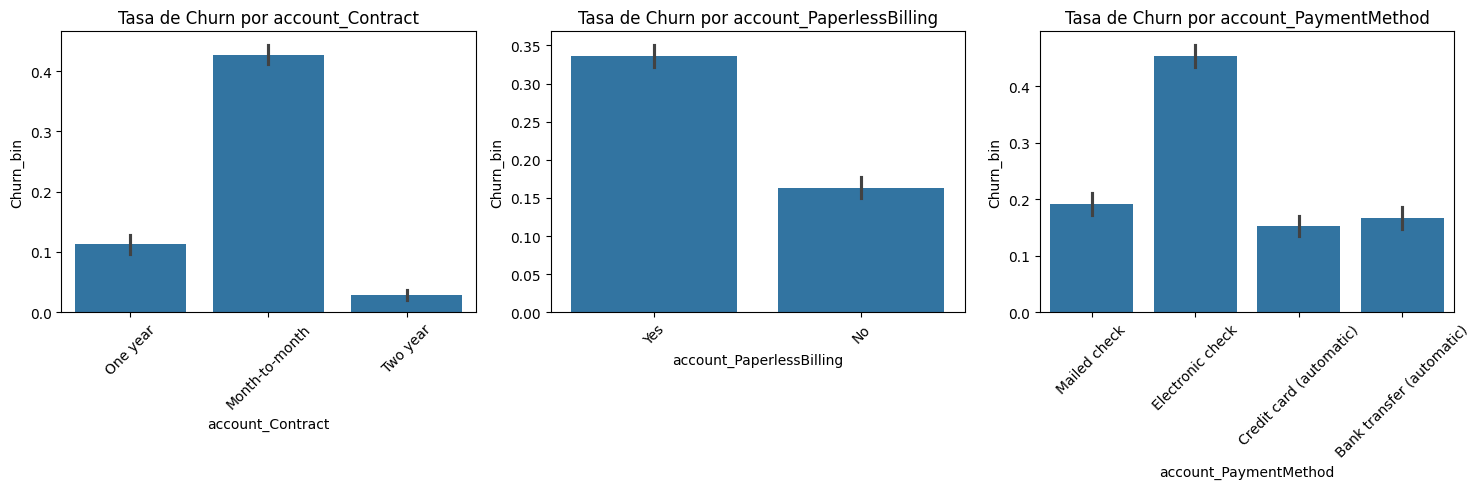

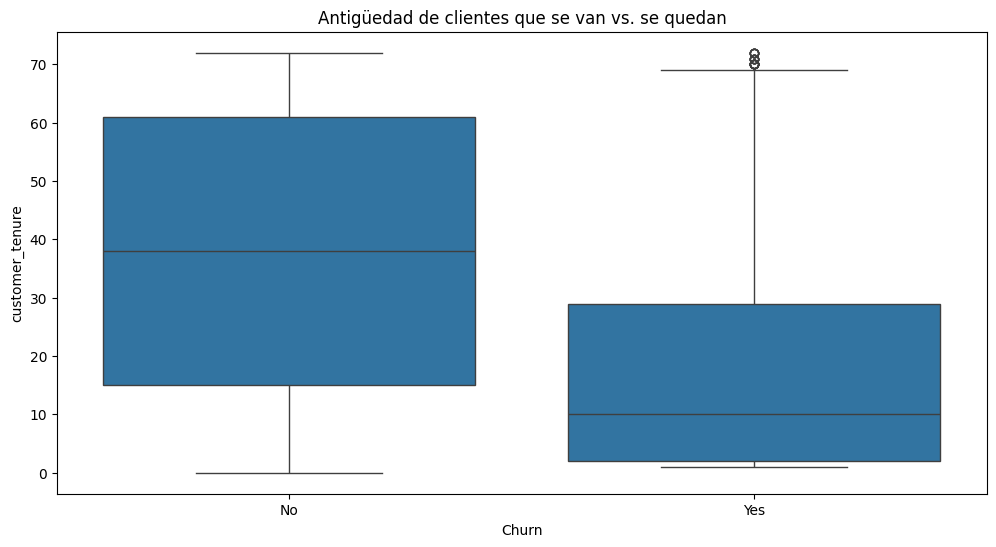

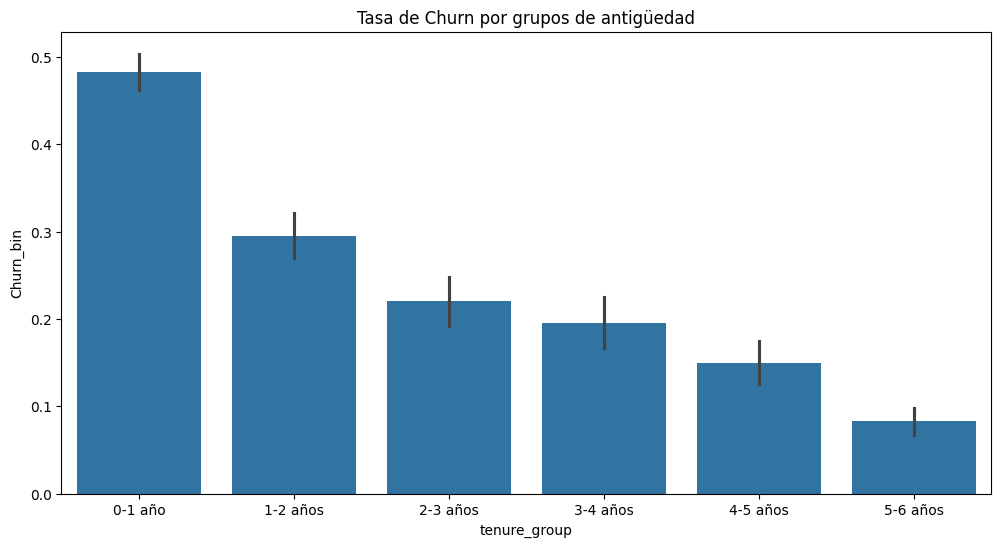

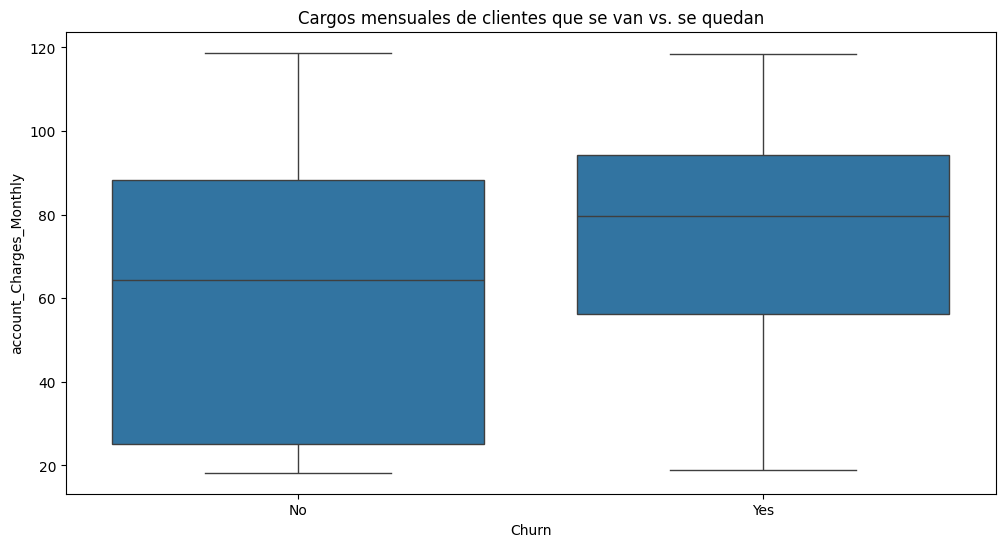

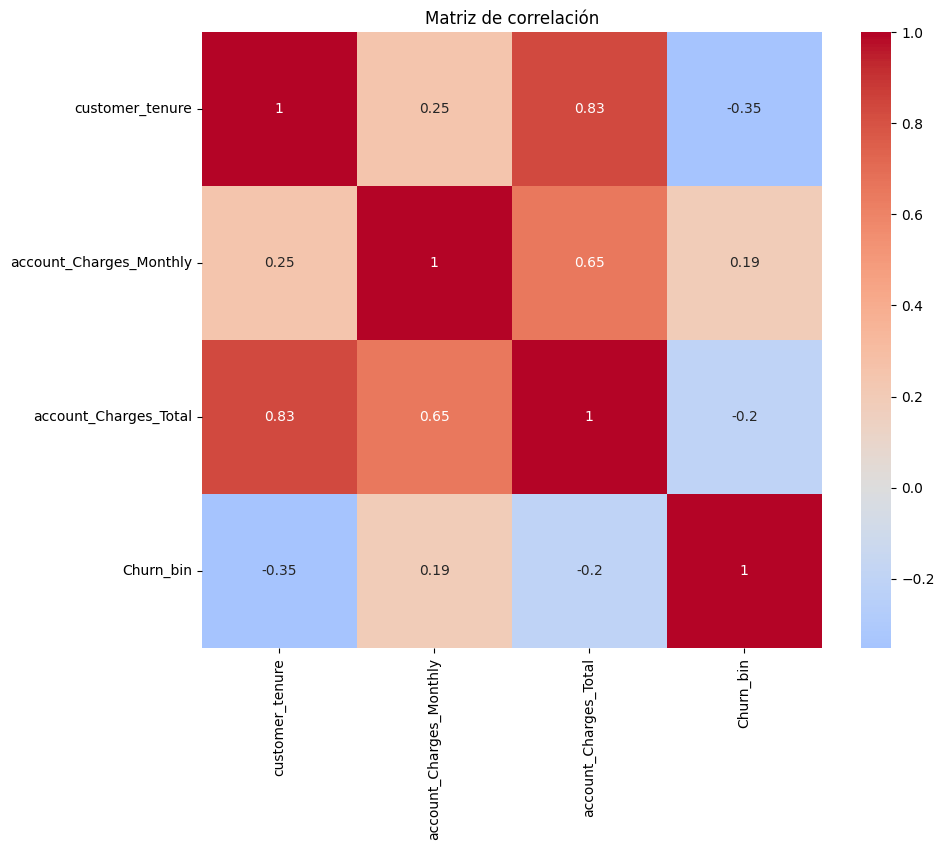

In [3]:
# Distribución de Churn
plt.figure(figsize=(8, 6))
sns.countplot(x='Churn', data=df)
plt.title('Distribución de Churn')
plt.show()

# Porcentaje de Churn
churn_rate = df['Churn_bin'].mean() * 100
print(f"Tasa de Churn: {churn_rate:.2f}%")

# Análisis por características demográficas
demographic_features = ['customer_gender', 'customer_SeniorCitizen', 'customer_Partner', 'customer_Dependents']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(demographic_features, 1):
    plt.subplot(2, 2, i)
    sns.barplot(x=feature, y='Churn_bin', data=df)
    plt.title(f'Tasa de Churn por {feature}')
plt.tight_layout()
plt.show()

# Análisis por servicios contratados
service_features = ['phone_PhoneService', 'phone_MultipleLines',
                   'internet_InternetService', 'internet_OnlineSecurity',
                   'internet_OnlineBackup', 'internet_DeviceProtection',
                   'internet_TechSupport', 'internet_StreamingTV',
                   'internet_StreamingMovies']

plt.figure(figsize=(15, 20))
for i, feature in enumerate(service_features, 1):
    plt.subplot(5, 2, i)
    sns.barplot(x=feature, y='Churn_bin', data=df)
    plt.title(f'Tasa de Churn por {feature}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Análisis por tipo de contrato y facturación
account_features = ['account_Contract', 'account_PaperlessBilling', 'account_PaymentMethod']
plt.figure(figsize=(15, 5))
for i, feature in enumerate(account_features, 1):
    plt.subplot(1, 3, i)
    sns.barplot(x=feature, y='Churn_bin', data=df)
    plt.title(f'Tasa de Churn por {feature}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Relación entre antigüedad y Churn
plt.figure(figsize=(12, 6))
sns.boxplot(x='Churn', y='customer_tenure', data=df)
plt.title('Antigüedad de clientes que se van vs. se quedan')
plt.show()

# Tasa de Churn por grupos de antigüedad
plt.figure(figsize=(12, 6))
sns.barplot(x='tenure_group', y='Churn_bin', data=df)
plt.title('Tasa de Churn por grupos de antigüedad')
plt.show()

# Relación entre cargos mensuales y Churn
plt.figure(figsize=(12, 6))
sns.boxplot(x='Churn', y='account_Charges_Monthly', data=df)
plt.title('Cargos mensuales de clientes que se van vs. se quedan')
plt.show()

# Correlación entre variables numéricas
numeric_features = ['customer_tenure', 'account_Charges_Monthly', 'account_Charges_Total', 'Churn_bin']
corr_matrix = df[numeric_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de correlación')
plt.show()

#📄Informe final

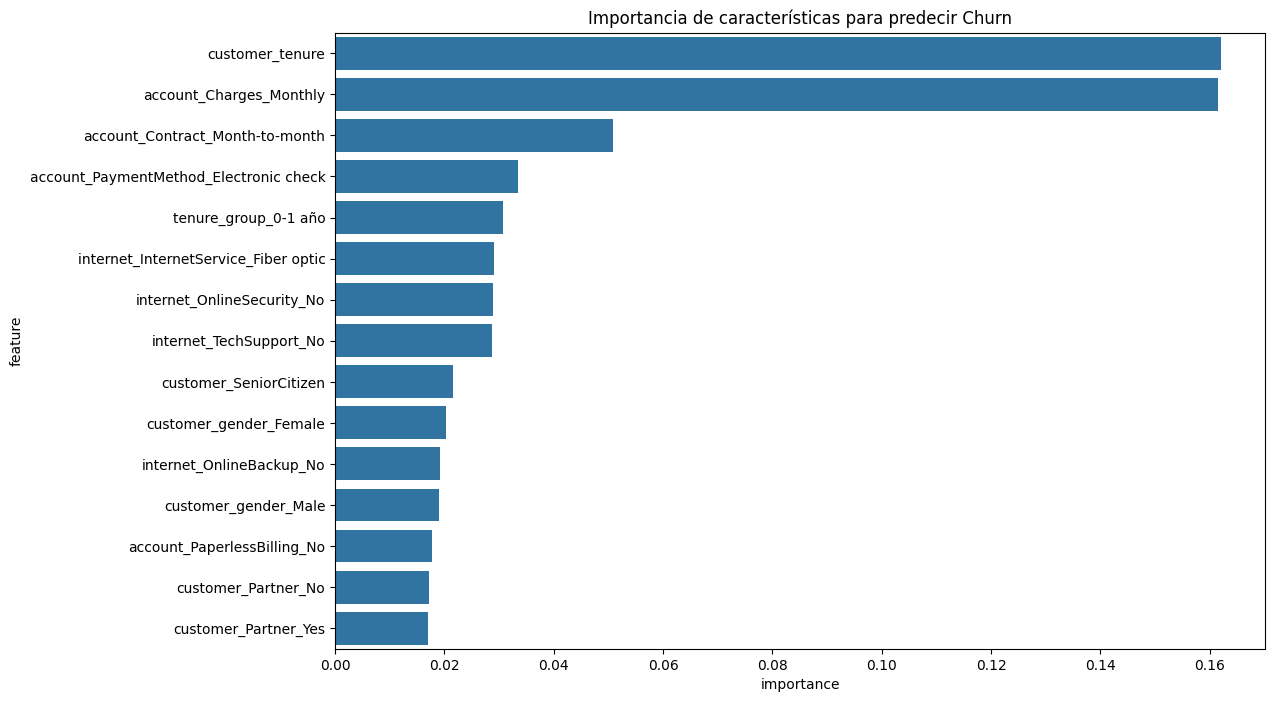

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Preparar datos para modelo
X = pd.get_dummies(df.drop(['customerID', 'Churn', 'Churn_bin', 'account_Charges_Total'], axis=1))
y = df['Churn_bin']

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenar modelo Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Importancia de características
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(15))
plt.title('Importancia de características para predecir Churn')
plt.show()

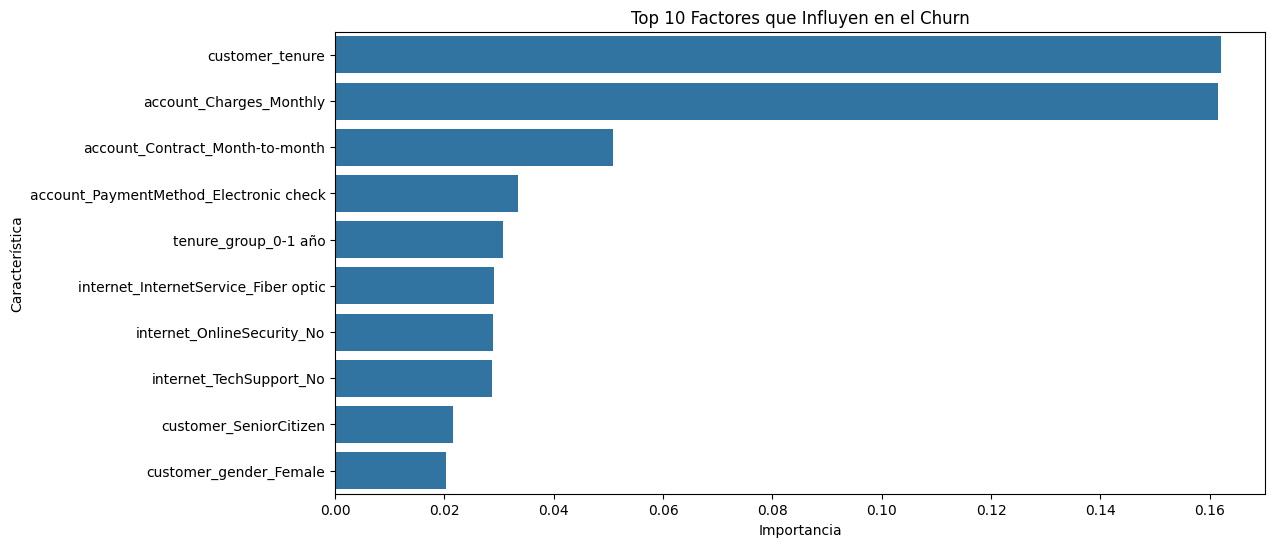

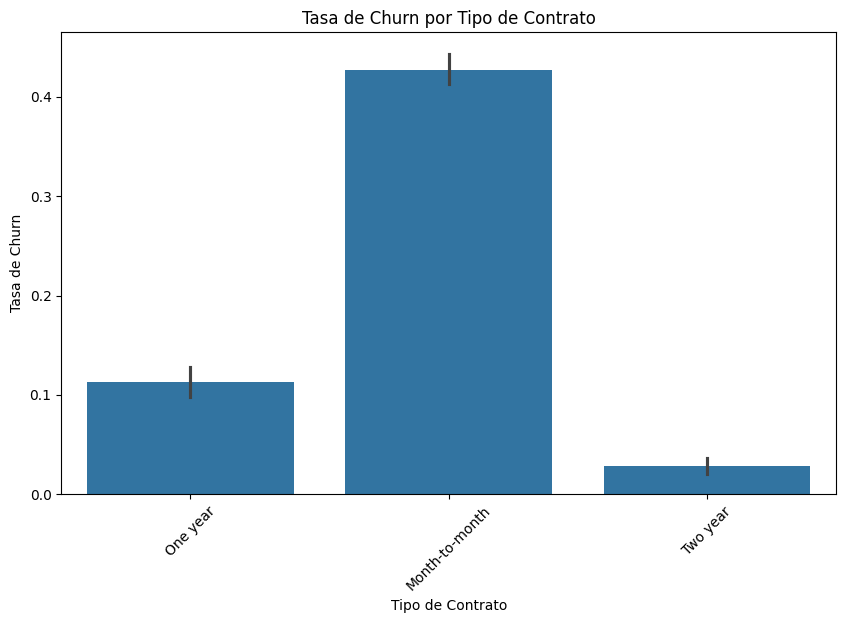

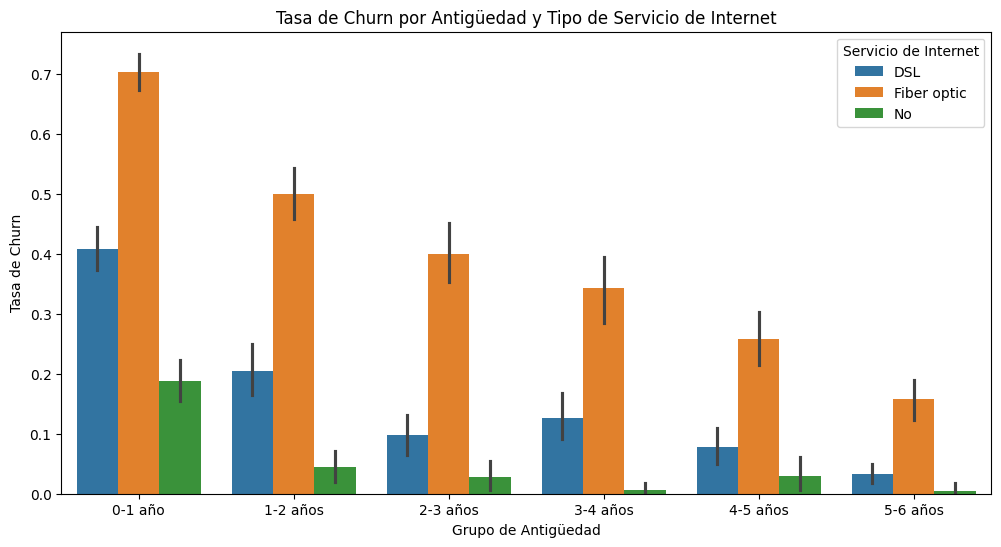

In [5]:
# Gráfico de los principales factores de churn
top_features = feature_importances.head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=top_features)
plt.title('Top 10 Factores que Influyen en el Churn')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.show()

# Comparación de churn por tipo de contrato
plt.figure(figsize=(10, 6))
sns.barplot(x='account_Contract', y='Churn_bin', data=df)
plt.title('Tasa de Churn por Tipo de Contrato')
plt.xlabel('Tipo de Contrato')
plt.ylabel('Tasa de Churn')
plt.xticks(rotation=45)
plt.show()

# Churn por antigüedad y tipo de servicio de internet
plt.figure(figsize=(12, 6))
sns.barplot(x='tenure_group', y='Churn_bin', hue='internet_InternetService', data=df)
plt.title('Tasa de Churn por Antigüedad y Tipo de Servicio de Internet')
plt.xlabel('Grupo de Antigüedad')
plt.ylabel('Tasa de Churn')
plt.legend(title='Servicio de Internet')
plt.show()

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1562
           1       0.60      0.45      0.51       551

    accuracy                           0.78      2113
   macro avg       0.71      0.67      0.68      2113
weighted avg       0.76      0.78      0.77      2113



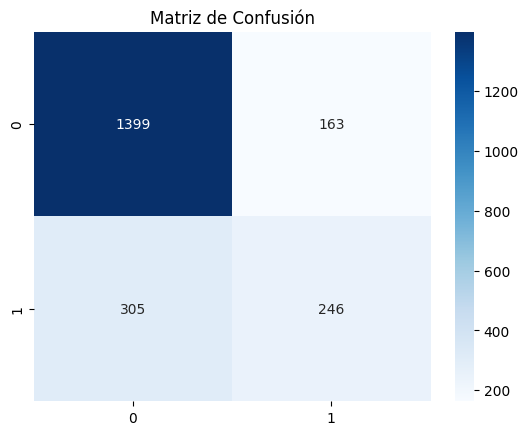

In [7]:
#evaluacion del modelo
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.show()

In [8]:
#validacion cruzada
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, X, y, cv=5, scoring='accuracy')
print(f"Precisión promedio: {scores.mean():.4f}")

Precisión promedio: 0.7838


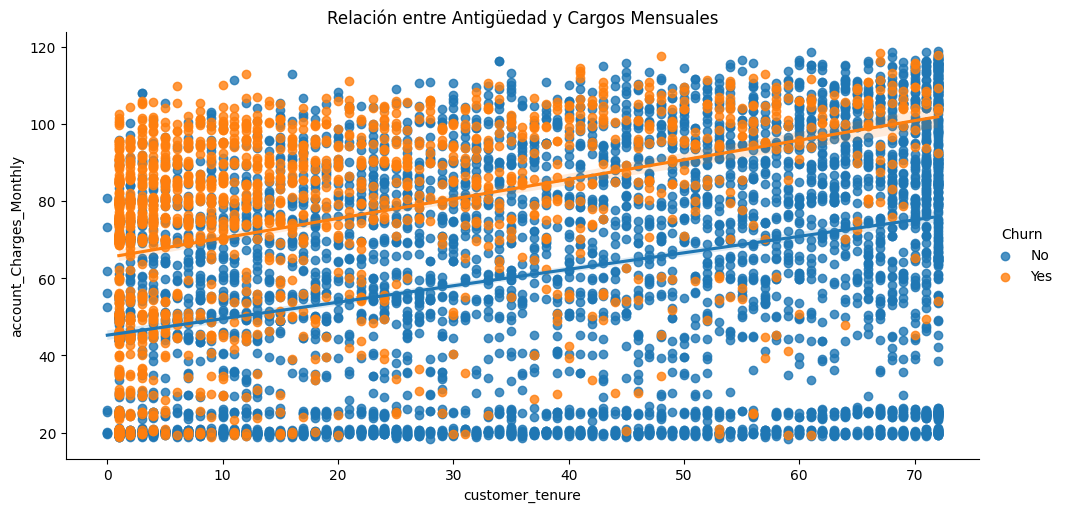

In [9]:
#grafico de dispersion con regresion
sns.lmplot(x='customer_tenure', y='account_Charges_Monthly', hue='Churn', data=df, aspect=2)
plt.title('Relación entre Antigüedad y Cargos Mensuales')
plt.show()

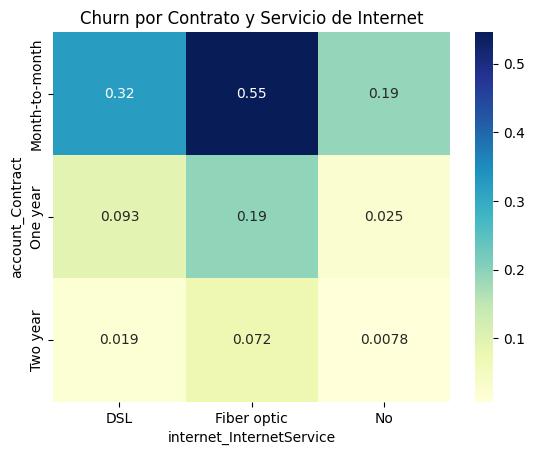

In [10]:
#mapa de calor de churn por contrato y servicio
pivot = df.pivot_table(index='account_Contract', columns='internet_InternetService', values='Churn_bin', aggfunc='mean')
sns.heatmap(pivot, annot=True, cmap='YlGnBu')
plt.title('Churn por Contrato y Servicio de Internet')
plt.show()

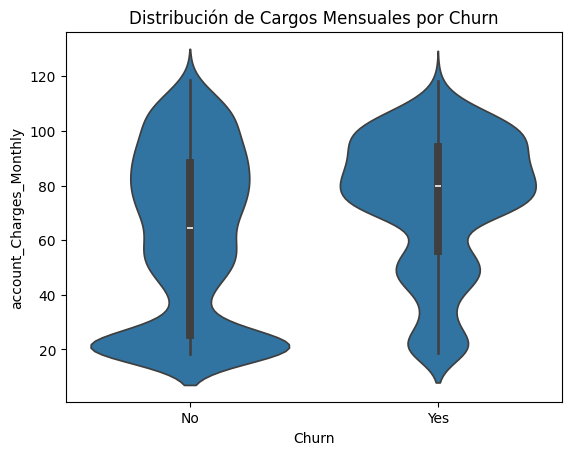

In [11]:
#grafico de violin para ver distribucion de cargos mensuales por churn
sns.violinplot(x='Churn', y='account_Charges_Monthly', data=df)
plt.title('Distribución de Cargos Mensuales por Churn')
plt.show()

In [12]:
#quines son los clientes con mayor riesgo de evasion
# Predecir probabilidades de churn
df['churn_prob'] = rf.predict_proba(X)[:, 1]

# Clientes con mayor riesgo
top_risk_clients = df[['customerID', 'churn_prob']].sort_values(by='churn_prob', ascending=False).head(10)
print("Clientes con mayor riesgo de evasión:")
print(top_risk_clients)

Clientes con mayor riesgo de evasión:
      customerID  churn_prob
6715  9248-OJYKK         1.0
2214  3091-FYHKI         1.0
2461  3428-XZMAZ         1.0
4015  5494-HECPR         1.0
3964  5419-JPRRN         1.0
911   1285-OKIPP         1.0
2191  3068-OMWZA         1.0
1267  1820-TQVEV         1.0
163   0259-GBZSH         1.0
3169  4424-TKOPW         1.0


/tmp/ipython-input-3456514147.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importances.head(10), palette='Reds_r')


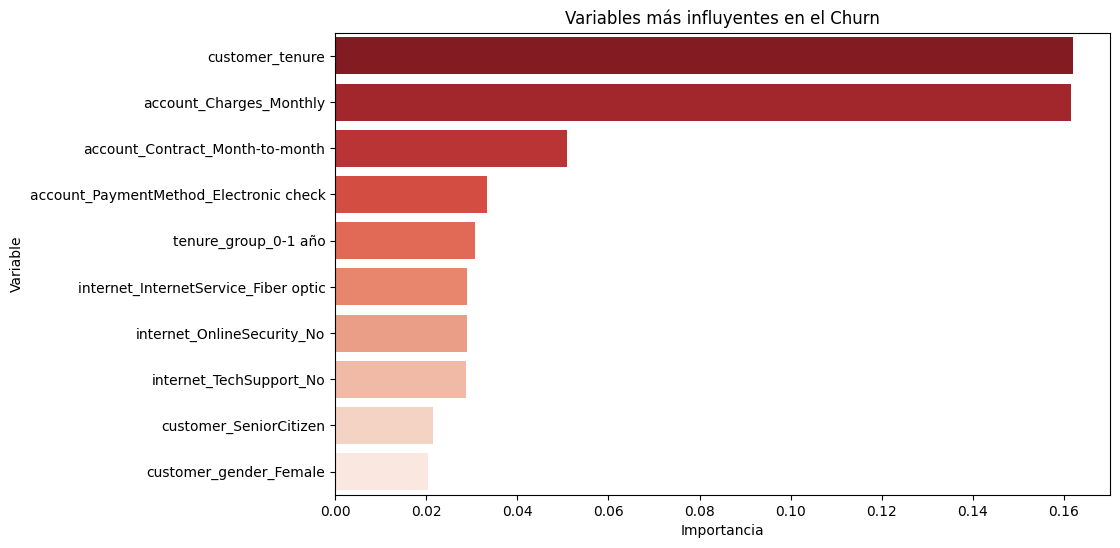

In [13]:
#variables que influyen mas en este comportamiento
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances.head(10), palette='Reds_r')
plt.title('Variables más influyentes en el Churn')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.show()

In [14]:
#que tipo de cliente necesita tener la empresa mas cerca
low_risk_clients = df[df['churn_prob'] < 0.2]
profile_summary = low_risk_clients.groupby('account_Contract')[['account_Charges_Monthly', 'customer_tenure']].mean()
print("Perfil promedio de clientes con baja evasión:")
print(profile_summary)

''' Análisis:
clientes con contrato a largo plazo (dos años o más)
antigüedad alta (más de 3 años)
cargos mensuales moderados
uso de servicios complementarios como seguridad, soporte técnico'''


Perfil promedio de clientes con baja evasión:
                  account_Charges_Monthly  customer_tenure
account_Contract                                          
Month-to-month                  56.141551        22.772853
One year                        60.364492        41.483587
Two year                        60.133495        56.705704


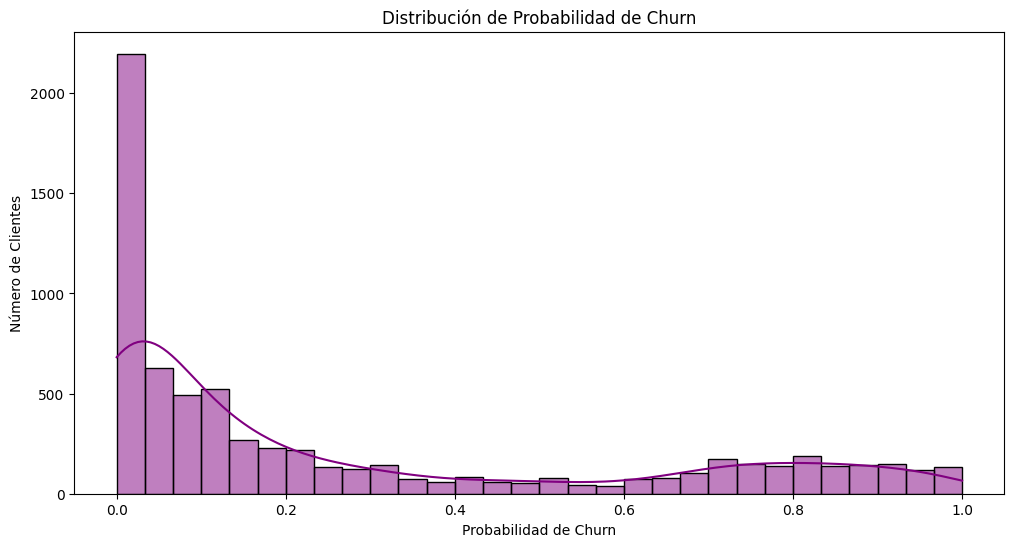

In [16]:
#prediccion y visualizacion de churn

# esto para una visualización simbólica del riesgo:

plt.figure(figsize=(12, 6))
sns.histplot(df['churn_prob'], bins=30, kde=True, color='purple')
plt.title('Distribución de Probabilidad de Churn')
plt.xlabel('Probabilidad de Churn')
plt.ylabel('Número de Clientes')
plt.show()

/tmp/ipython-input-1410759851.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='account_Contract', y='churn_prob', data=df, palette='coolwarm')


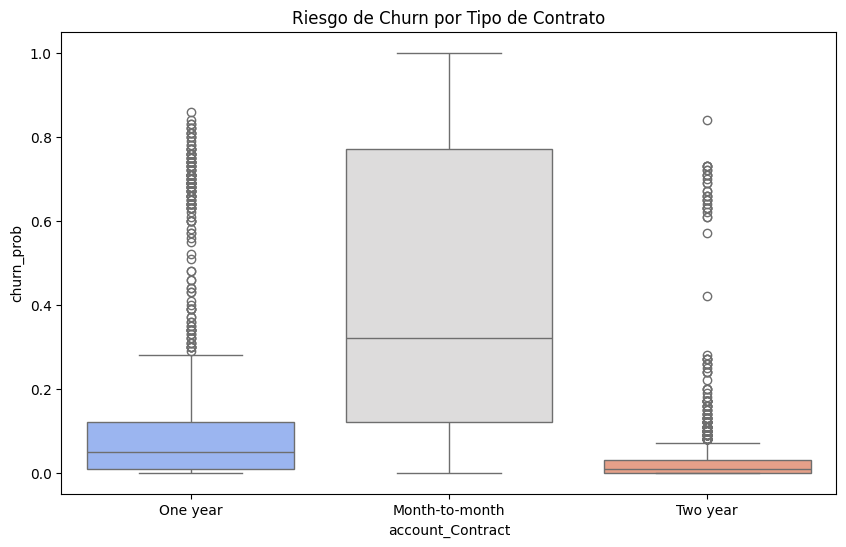

In [17]:
# como se distribuye el riesgo por el tipo de contrato :

plt.figure(figsize=(10, 6))
sns.boxplot(x='account_Contract', y='churn_prob', data=df, palette='coolwarm')
plt.title('Riesgo de Churn por Tipo de Contrato')
plt.show()

/tmp/ipython-input-3692563425.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=years_labels, y=sales_projection, palette='mako')


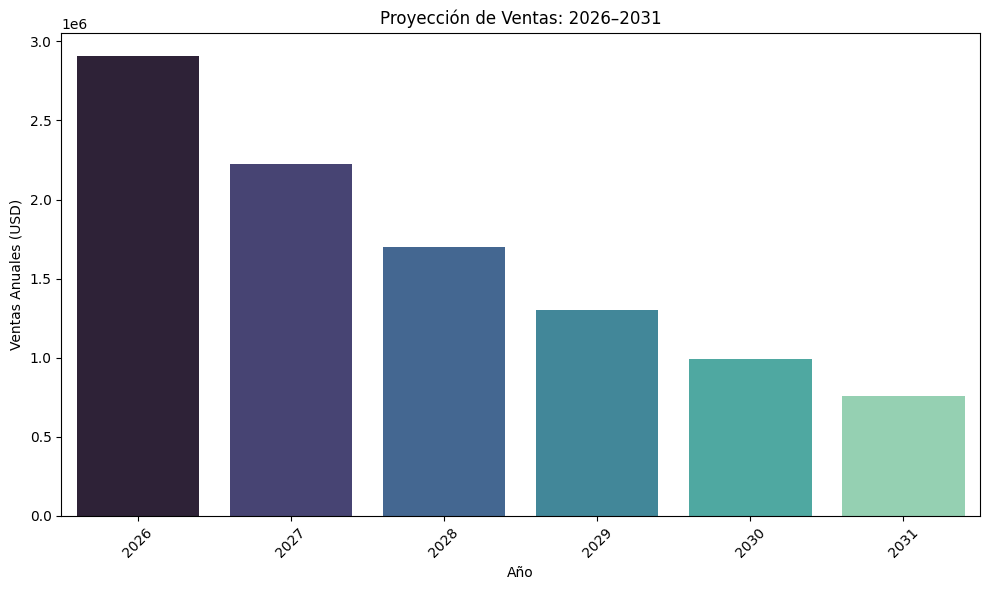

    Año  Clientes Proyectados  Ventas Proyectadas (USD)
0  2026                  3956                2908522.26
1  2027                  3025                2223943.75
2  2028                  2313                1700494.40
3  2029                  1769                1300249.25
4  2030                  1352                 994209.75
5  2031                  1034                 760202.73


In [20]:
# prediccion de ventas dentro de 5 años :
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#calculando ingreso mensual promedio por cliente activo
active_clients = df[df['Churn_bin'] == 0]
monthly_avg_revenue = active_clients['account_Charges_Monthly'].mean()

#calculando número actual de clientes activos
current_clients = len(active_clients)

#suposiciones para proyección
annual_churn_rate = df['Churn_bin'].mean()  # tasa promedio de churn
growth_rate = 0.03  # crecimiento anual de nuevos clientes
years = 6
start_year = 2026

#simulación de ventas por año
sales_projection = []
clients_projection = []

clients = current_clients
for year in range(start_year, start_year + years):
    clients = clients * (1 - annual_churn_rate) + (clients * growth_rate)
    annual_sales = clients * monthly_avg_revenue * 12
    clients_projection.append(clients)
    sales_projection.append(annual_sales)


years_labels = [str(y) for y in range(start_year, start_year + years)]
plt.figure(figsize=(10, 6))
sns.barplot(x=years_labels, y=sales_projection, palette='mako')
plt.title('Proyección de Ventas: 2026–2031')
plt.ylabel('Ventas Anuales (USD)')
plt.xlabel('Año')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#tabla resumen
projection_df = pd.DataFrame({
    'Año': years_labels,
    'Clientes Proyectados': np.round(clients_projection).astype(int),
    'Ventas Proyectadas (USD)': np.round(sales_projection, 2)
})
print(projection_df)